**Table of contents**<a id='toc0_'></a>    
- [Computing the transition in the HANC model - manually!](#toc1_)    
  - [Previous code to compute the stationary equilibrium](#toc1_1_)    
  - [Partial equilibrium transition](#toc1_2_)    
  - [Transitions in general equilibrium](#toc1_3_)    
    - [A shooting algorithm](#toc1_3_1_)    
    - [A 'manual Jacobian' approach](#toc1_3_2_)    
    - [The Fake-News algorithm](#toc1_3_3_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
import numpy as np
import numba as nb 
from consav.linear_interp import interp_1d_vec
from EconModel import jit
from HANCModel import HANCModelClass
import matplotlib.pyplot as plt
from consav.grids import equilogspace
from consav.markov import log_rouwenhorst

# <a id='toc1_'></a>[Computing the transition in the HANC model - manually!](#toc0_)

We compute a transition in the same model we used last week.

In [2]:
class Parameters:
    def __init__(self):
        # preferences
        self.beta = 0.9498866874132476
        self.sigma = 1.0
        
        # production
        self.alpha = 1/3
        self.delta = 0.1/3
        self.Gamma = 1.0
        
        # grids
        self.Na = 500
        self.a_min = 0.0
        self.a_max = 10_000.0 
        self.a_grid = equilogspace(self.a_min,self.a_max,self.Na)

        # income
        self.rho_z = 0.95
        self.sigma_psi = 0.30*(1.0-self.rho_z**2.0)**0.5
        self.Nz = 7
        self.z_grid, self.z_trans,self.z_ergodic,_,_ = log_rouwenhorst(self.rho_z,self.sigma_psi,self.Nz)
        

par = Parameters()

## <a id='toc1_1_'></a>[Previous code to compute the stationary equilibrium](#toc0_)

First, we reuse some of the functions we wrote last week to solve the household block.

In [3]:
""" 
Household backward step
"""

def egm_ss(r, w, par, max_iter = 50_000, tol = 1e-12, verbose = False):
    """ solve the EGM for the steady state """

    # a. initialize
    y = w*par.z_grid
    c = r*par.a_grid[np.newaxis,:] + y[:,np.newaxis] 
    Va = (1+r)*c**(-par.sigma)

    # b. iterate
    for it in range(max_iter):

        # i. solve backwards
        c, a, Va_new = solve_hh_backwards_one_step(par.z_trans, par.z_grid, par.a_grid, par.sigma, par.beta, r, w, Va)

        # ii. check convergence
        error = np.max(np.abs(Va - Va_new))
        if verbose:
            print(error)
        if error < tol:
            return c, a, Va_new

        Va = Va_new
    
    

def solve_hh_backwards_one_step(z_trans, z_grid, a_grid, sigma, beta, r, w, vbeg_a):

    # vbeg_a is the derivative of the value function at the beginning of the period
    Nz, Na = vbeg_a.shape
    a = np.zeros((Nz, Na))
    c = np.zeros((Nz, Na)) 
    
    # a. solve step
    for i_z in range(Nz):
    
        ## i. get c(a',z)
        c_endo = (beta*vbeg_a[i_z])**(-1/sigma)
        
        # ii. compute m_endo = c(a',z) + a'
        m_endo = c_endo + a_grid # current consumption + end-of-period assets
        
        # iii. interpolation to fixed grid
        m = (1+r)*a_grid + w*z_grid[i_z] # exogenous grid of coh
        interp_1d_vec(m_endo,a_grid,m,a[i_z]) # fill up the array a[i_z]
        a[i_z,:] = np.fmax(a[i_z,:],0.0) # enforce borrowing constraint
        c[i_z] = m-a[i_z]

    # b. expectation step
    RHS = (1+r)*c**(-sigma)
    vbeg_a_new = z_trans @ RHS

    return c, a, vbeg_a_new


In [4]:
""" 
Household forward step
"""

def get_lottery(a, a_grid):
    # step 1: find the i such that a' lies between gridpoints a_i and a_(i+1)
    a_i = np.searchsorted(a_grid, a, side='right') - 1
    a_i = np.clip(a_i, 0, len(a_grid)-2)

    # step 2: implement (8) to obtain lottery probabilities pi
    a_pi = (a_grid[a_i+1] - a)/(a_grid[a_i+1] - a_grid[a_i])
    
    return a_i, a_pi

@nb.njit
def forward_policy(D, a_i, a_pi):
    Dend = np.zeros_like(D)
    for e in range(a_i.shape[0]):
        for a in range(a_i.shape[1]):
            # send pi(e,a) of the mass to gridpoint i(e,a)
            Dend[e, a_i[e,a]] += a_pi[e,a]*D[e,a]
            
            # send 1-pi(e,a) of the mass to gridpoint i(e,a)+1
            Dend[e, a_i[e,a]+1] += (1-a_pi[e,a])*D[e,a]
            
    return Dend

@nb.njit
def forward_iteration(D, z_trans, a_i, a_pi):
    Dend = forward_policy(D, a_i, a_pi)    
    return z_trans.T @ Dend

def distribution_ss(a, par, tol=1E-10):
    a_i, a_pi = get_lottery(a, par.a_grid)

    # as initial D, use stationary distribution for s, plus uniform over a
    D = par.z_ergodic[:, np.newaxis] * np.ones_like(par.a_grid) / len(par.a_grid)

    # now iterate until convergence to acceptable threshold
    for _ in range(100_000):
        D_new = forward_iteration(D, par.z_trans, a_i, a_pi)
        if np.max(np.abs(D_new - D)) < tol:
            return D_new
        D = D_new



In [5]:
""" 
Household block steady-state
"""

def household_ss(r, w, par, max_iter = 10_000, tol = 1e-8, verbose = False):
    c, a, Va = egm_ss(r, w, par, max_iter, tol, verbose) 
    D = distribution_ss(a, par)
    A = np.sum(D * a)
    C = np.sum(D * c) 
    return A, C, D, a, c, Va 

In [6]:
def find_ss_beta(beta, par):
    par.beta = beta
    r = 0.05
    w = 1-par.alpha
    K = 4 
    A, _, _, _, _, _  = household_ss(r, w, par) 
    print(A-K)
    return A-K

from scipy.optimize import brentq 
par.beta = brentq(find_ss_beta, 0.9, 0.952, args=(par,))

r_ss = 0.05 
Y_ss = 1 
K_ss = 4 
par.alpha = 1/3 
par.Gamma = Y_ss /(K_ss**par.alpha)
par.delta = par.alpha * par.Gamma * K_ss**(par.alpha-1) - r_ss
w_ss = (1-par.alpha) * Y_ss
A_ss, C_ss, D_init, a_ss, c_ss, Va_term = household_ss(r_ss, w_ss, par) 

-3.9999999999999987
18.850971301144178
-3.9999999999999964
-3.975423715491448
-3.690302699991704
-2.7649965573647464
-0.8924888421928925
1.3487170555343484
-0.21485529404579662
0.009983083845258811
-0.0004332611687845045
-8.180241333199945e-07
2.204991744747531e-11
-1.881705014028512e-09


## <a id='toc1_2_'></a>[Partial equilibrium transition](#toc0_)

In a heterogeneous-agent model, we need to compute the policy functions and the distribution when the households face a **path of prices** $(w_t,r_t)_{t\geq 0}$. 

Important assumption: 
- Initial conditions: we compute the transition from a given distribution $D_0$ that we already know
- Terminal condition: we compute a transition towards some stationary state where we know the value function (or its derivative)

It is useful to distinguish two times of transitions:
- Transitory ones: both the initial and terminal conditions are the steady-state values 
- Permanent ones: the economy moves from one state to another state (the terminal state must be a stationary one)

Once we have picked up a $D_0$ and $Va_T$, we can compute the transition for a given path of prices $(w_t,r_t)_{t=0}^T$ in two steps:

1. **Backward step:** for every period $t$ in $(T,0)$, solve the problem of the household $V_t(a_t,z_t)=\max u(c_t)+\beta \mathbb{E}_t[V_{t+1}(a_{t+1},z_{t+1})]$ **backward in time** and obtain the **time-varying** policy functions $a_t(a,z)$ and $c_t(a,z)$ (using our terminal condition)
2. **Forward step:** for every period $t$ in $(0,T)$ use the policy functions to update the distribution over time, using the histogram method 

**Question**: *Can you figure out why we call this a perfect foresight transition? Where is this assumption baked-in?*

For the sake of simplicity, we will use the stationary equilibrium we just computed, and see what happens if we increase arbitrarily wages by 1% at period $t=0$.

First, let's do the backward step. We initialize the algorithm with our terminal condition, and then apply the EGM step for every $t\in(T,0)$, 

In [7]:
T = 1000
r_vec = np.ones((T)) * r_ss
w_vec = np.ones((T)) * w_ss
w_vec[0] = w_vec[0] * 1.01


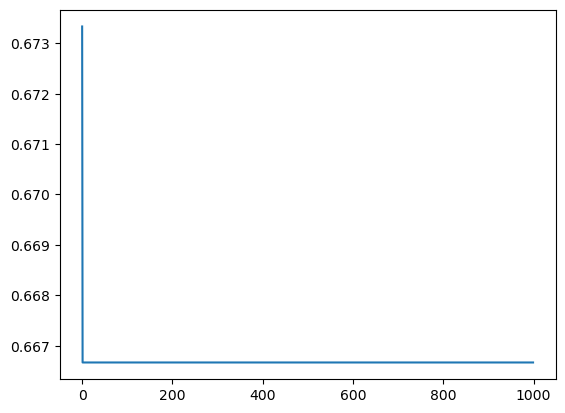

In [8]:
plt.plot(w_vec)

In [9]:

a_trans = np.zeros((T, par.Nz, par.Na))
c_trans = np.zeros((T, par.Nz, par.Na))
Va_trans = Va_term.copy() # Terminal condition

for t in reversed(range(T)):
    print(t)
    c_trans[t], a_trans[t], Va_trans = solve_hh_backwards_one_step(par.z_trans, 
                                                                   par.z_grid, 
                                                                   par.a_grid, 
                                                                   par.sigma, 
                                                                   par.beta, 
                                                                   r_vec[t], 
                                                                   w_vec[t], 
                                                                   Va_trans)
    # note that w_vec[t] and r_vec[t] are time-varying
    # note that Va_trans is updated every iteration

print(a_trans.shape)
print(c_trans.shape)
# note the new dimensions of the policy functions: first dimension is time.

999
998
997
996
995
994
993
992
991
990
989
988
987
986
985
984
983
982
981
980
979
978
977
976
975
974
973
972
971
970
969
968
967
966
965
964
963
962
961
960
959
958
957
956
955
954
953
952
951
950
949
948
947
946
945
944
943
942
941
940
939
938
937
936
935
934
933
932
931
930
929
928
927
926
925
924
923
922
921
920
919
918
917
916
915
914
913
912
911
910
909
908
907
906
905
904
903
902
901
900
899
898
897
896
895
894
893
892
891
890
889
888
887
886
885
884
883
882
881
880
879
878
877
876
875
874
873
872
871
870
869
868
867
866
865
864
863
862
861
860
859
858
857
856
855
854
853
852
851
850
849
848
847
846
845
844
843
842
841
840
839
838
837
836
835
834
833
832
831
830
829
828
827
826
825
824
823
822
821
820
819
818
817
816
815
814
813
812
811
810
809
808
807
806
805
804
803
802
801
800
799
798
797
796
795
794
793
792
791
790
789
788
787
786
785
784
783
782
781
780
779
778
777
776
775
774
773
772
771
770
769
768
767
766
765
764
763
762
761
760
759
758
757
756
755
754
753
752
751
750


And we have obtained our policy functions! We can now use our forward step algorithm to compute the change in the distribution over time.

In [10]:
D_trans = np.zeros((T, par.Nz, par.Na))
D_trans[0] = D_init 

for t in range(T-1):
    a_i, a_pi = get_lottery(a_trans[t], par.a_grid)
    D_trans[t+1] = forward_iteration(D_trans[t], par.z_trans, a_i, a_pi)

For clarity, we can put this code in a function, with a `@nb.njit` decorator to speed things up a little.

In [11]:
@nb.njit
def forward_iteration_trans(D_init, z_trans, a_i, a_pi, T):
    Nz, Na = D_init.shape
    D = np.zeros((T, Nz, Na))
    D[0] = D_init
    for t in range(T-1):
        D[t+1] = forward_iteration(D[t], z_trans, a_i[t], a_pi[t])
    return D

We now have the policy functions and the distribution, and we can obtain aggregate values by summing over the two last dimensions.

In [12]:
A_trans = np.sum(D_trans * a_trans, axis = (1,2)) # axis = (1,2) means sum over the dimensions 1 and 2 but keep dimension 0
C_trans = np.sum(D_trans * c_trans, axis = (1,2))

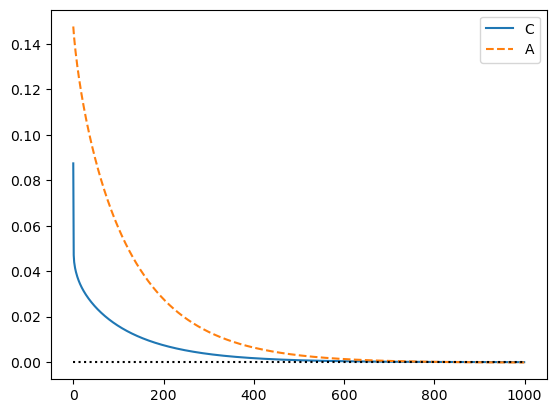

In [13]:
plt.plot(100*(C_trans-C_ss)/C_ss, label = 'C')
plt.plot(100*(A_trans-A_ss)/A_ss, label = 'A', linestyle = '--')
plt.plot(np.zeros_like(A_trans), linestyle = ':', color = 'black')
plt.legend()
plt.show()

Let's put those two steps together, and we obtain a function that takes as in puts:
1. A terminal condition `Va_term`
2. An initial condition `D_init` 
3. A vector of time-varying interest rate 
4. A vector of time-varying wages 

and some parameters. This is enough to compute a **partial-equilibrium** transition of the household block: given some prices, what will be the policy functions, distribution, and the aggregate values of households?

In [14]:
def get_impulse_response(Va_term, D_init, r_vec, w_vec, par):
    # backward step
    a_trans = np.zeros((T, par.Nz, par.Na))
    c_trans = np.zeros((T, par.Nz, par.Na))
    Va_trans = Va_term.copy()
    for t in reversed(range(T)):
        c_trans[t], a_trans[t], Va_trans = solve_hh_backwards_one_step(par.z_trans, 
                                                                       par.z_grid, 
                                                                       par.a_grid, 
                                                                       par.sigma, 
                                                                       par.beta, 
                                                                       r_vec[t], 
                                                                       w_vec[t], 
                                                                       Va_trans)

    # forward step
    D_trans = np.zeros((T, par.Nz, par.Na))
    D_trans[0] = D_init
    a_i, a_pi = get_lottery(a_trans, par.a_grid)

    D_trans = forward_iteration_trans(D_init, par.z_trans, a_i, a_pi, T)    
    A_trans = np.sum(D_trans * a_trans, axis = (1,2))
    C_trans = np.sum(D_trans * c_trans, axis = (1,2))

    return C_trans, A_trans, D_trans, c_trans, a_trans

**Exercise:** compute a transition following a shock on $r$ at $t=20$, and plot your results 

In [15]:
# Code here
r_shock = r_ss * (1.01)
r_vec = np.ones((T)) * r_ss
w_vec = np.ones((T)) * w_ss

r_vec[100] = r_shock

C_trans, A_trans, D_trans, c_trans, a_trans = get_impulse_response(Va_term, D_init, r_vec, w_vec, par)


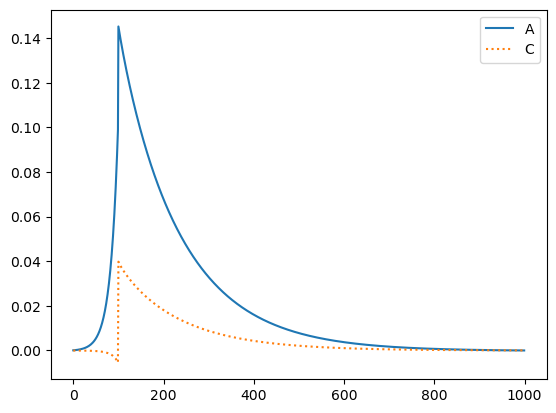

In [16]:
plt.plot((A_trans-A_ss) / A_ss * 100, label = 'A')
plt.plot((C_trans-C_ss) / C_ss * 100, label = 'C', linestyle = ':')
plt.legend()
plt.show()

## <a id='toc1_3_'></a>[Transitions in general equilibrium](#toc0_)

To solve for the general equilibrium following an exogenous shock, we need to find the sequence of endogenous variables $K$ such that markets clear. 

First, let us define a new `firm` function that returns `r`, `w`, `Y`, and `I`, for a path of `K`. Note that we need to account for the timing of production: $Y_t$ depends on $K_{t-1}$. 

In [17]:
def firm(K, Gamma, K_init, par): 
    K_vec = K.copy()
    K_vec[1:] = K[:-1]
    K_vec[0] = K_init # K_vec is a vector of K_{t-1}

    Y = Gamma * K_vec**par.alpha # Y is a vector of K_t
    I = K - (1-par.delta) * K_vec
    r = par.alpha * Y/K_vec - par.delta # r is the interest you receive at t
    w = (1-par.alpha) * Y # w is the wage you receive at t 
    return r, w, Y, I

Now, let's simulate a positive TFP shock with persistence $\rho$. For now, assume that $\{K_t\}_{t=0}^T=K_{ss}$. Since $\Gamma_t$ increases over time, $r_t,w_t$ will change over time as well. 

In [18]:
K_path = np.ones((T)) * K_ss 
Gamma_path = np.ones((T)) * par.Gamma 

r, w, Y, I = firm(K_path, Gamma_path, K_ss, par)

In [19]:
r 

array([0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.

<>:9: SyntaxWarning: invalid escape sequence '\G'
<>:12: SyntaxWarning: invalid escape sequence '\G'
<>:9: SyntaxWarning: invalid escape sequence '\G'
<>:12: SyntaxWarning: invalid escape sequence '\G'
/var/folders/hn/dsqvtr1n09z9k135wwh_g7280000gn/T/ipykernel_93944/1156489329.py:9: SyntaxWarning: invalid escape sequence '\G'
  plt.plot((Gamma_shock-par.Gamma)/par.Gamma*100, label = '$\Gamma$')
/var/folders/hn/dsqvtr1n09z9k135wwh_g7280000gn/T/ipykernel_93944/1156489329.py:12: SyntaxWarning: invalid escape sequence '\G'
  plt.title("Percentage change in $\Gamma, r, w$")


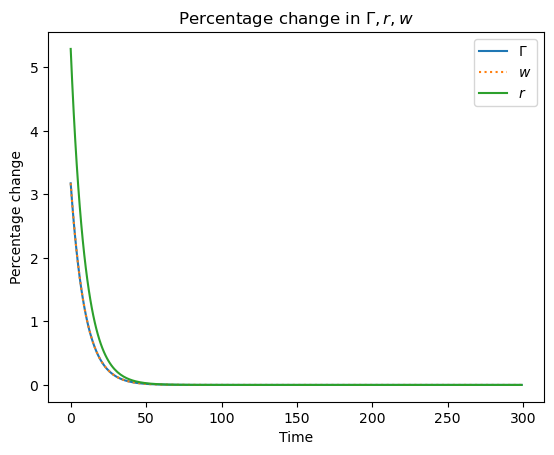

In [20]:
T = 300
sigma = 0.02
rho = 0.9
Gamma_shock = par.Gamma + sigma * rho ** np.arange(T)

K_vec = np.ones((T)) * K_ss
r_vec, w_vec, Y_vec, I_vec = firm(K_vec, Gamma_shock, K_ss, par)

plt.plot((Gamma_shock-par.Gamma)/par.Gamma*100, label = '$\Gamma$')
plt.plot((w_vec-w_ss)/w_ss*100, label = '$w$', linestyle = ':')
plt.plot((r_vec-r_ss)/r_ss*100, label = '$r$')
plt.title("Percentage change in $\Gamma, r, w$")
plt.xlabel("Time")
plt.ylabel("Percentage change")
plt.legend()
plt.show()

We can solve the impulse reponse of households to this path of $\{r_t,w_t\}_{t=0}^T$, and compute market clearing. 

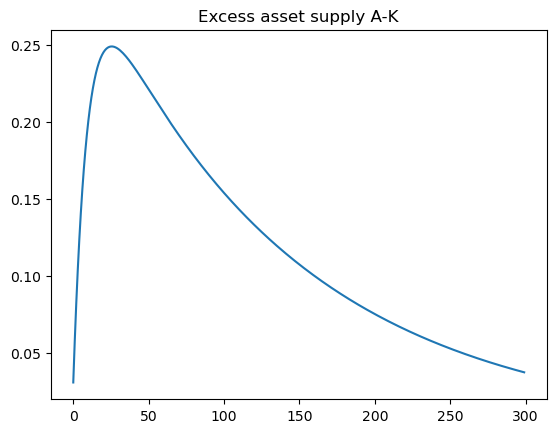

In [21]:
K_trans = np.ones((T)) * K_ss
r_trans, w_trans, Y_trans, I_trans, = firm(K_trans, Gamma_shock, K_ss, par)

C_trans, A_trans, D_trans, c_trans, a_trans = get_impulse_response(Va_term, D_init, r_trans, w_trans, par)
asset_market = A_trans - K_trans
plt.plot(asset_market)
plt.title('Excess asset supply A-K')
plt.show()

The goal is to take this to zero!

### <a id='toc1_3_1_'></a>[A shooting algorithm](#toc0_)

A first "naive" algorithm is the following algorithm.

First, initialize the sequence of $K_t=K_{ss}$. Then, iterate until convergence on:

1. Compute the path for $r_t,w_t,Y_t,I_t$ using the equations of the firm
2. Solve the houehold block for this given path of $r,w$ 
3. Check the market clearing condition: $A^{hh}_t - K_t$ 
4. Update the endogenous variable like this $K_t^{n+1}=(1-adj) K_t^n + adj A_t^{hh}$ 

It turns out that this works, but it takes a lot of iterations to converge, and it's very dependent on the updating factor we use.

In some harder models, it's also unclear which updating rule we should use.

In [22]:
K_trans = np.ones((T)) * K_ss
error = 1 
tol = 1e-8
adj = 0.1
while error > tol:
    r_trans, w_trans, Y_trans, I_trans = firm(K_trans, Gamma_shock, K_ss, par)
    C_trans, A_trans, D_trans, c_trans, a_trans = get_impulse_response(Va_term, D_init, r_trans, w_trans, par)
    asset_market = A_trans - K_trans
    error = np.max(np.abs(asset_market))
    print(error)
    K_trans = (1-adj) * K_trans + adj * A_trans


0.2488828875265936
0.15449430018098909
0.11629314131075708
0.08184290442863595
0.0644394615343602
0.05181627792031662
0.04231223230407988
0.034847185049771134
0.029040840964727366
0.024323109654705632
0.020455934113408958
0.017354366032796165
0.014760106333594258
0.01258136104241725
0.010745178918252662
0.00922997949480564
0.00795113898936961
0.006858772014136427
0.005923783100071134
0.0051220294766292085
0.0044333833943071
0.003840995736061892
0.0033403170313999198
0.002911902116686349
0.002540288049377004
0.0022176122384838237
0.0019371627275708292
0.0016931974367153657
0.0014807945231343211
0.0012957276511436078
0.0011343618698154145
0.0009935661025926024
0.00087063956296074
0.0007632495918521442
0.0006696332767210933
0.0005896637532858406
0.0005194271352237934
0.0004577104231540119
0.00040345635743399555
0.0003557426768061589
0.00031376424797091573
0.0002768176733507488
0.0002442880099664535
0.00021563729363460737
0.00019039461030700977
0.00016814749722282585
0.00014853448581853002

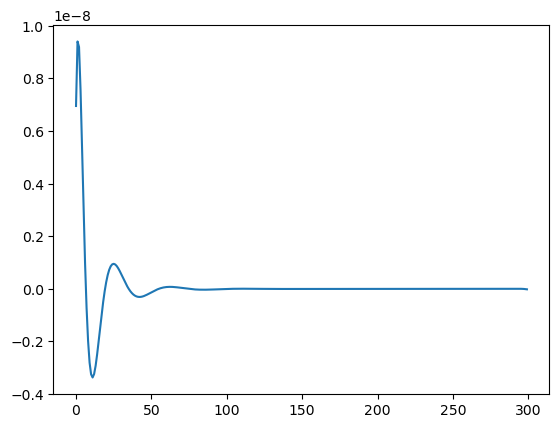

In [23]:
plt.plot(asset_market)

But, nonetheless, we have solved our first transition path! We can check that things make sense, and that the goods market clearing condition also holds (which it should, given Walras' law).

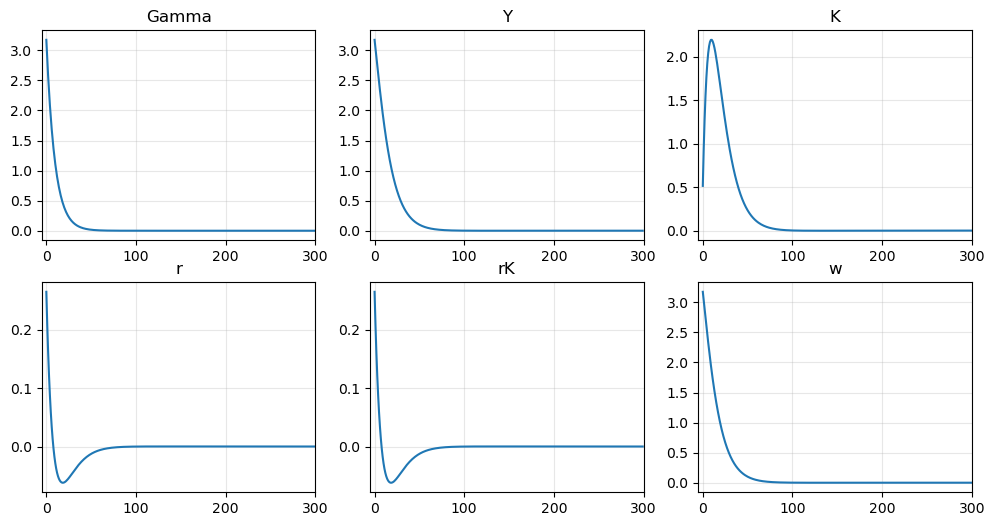

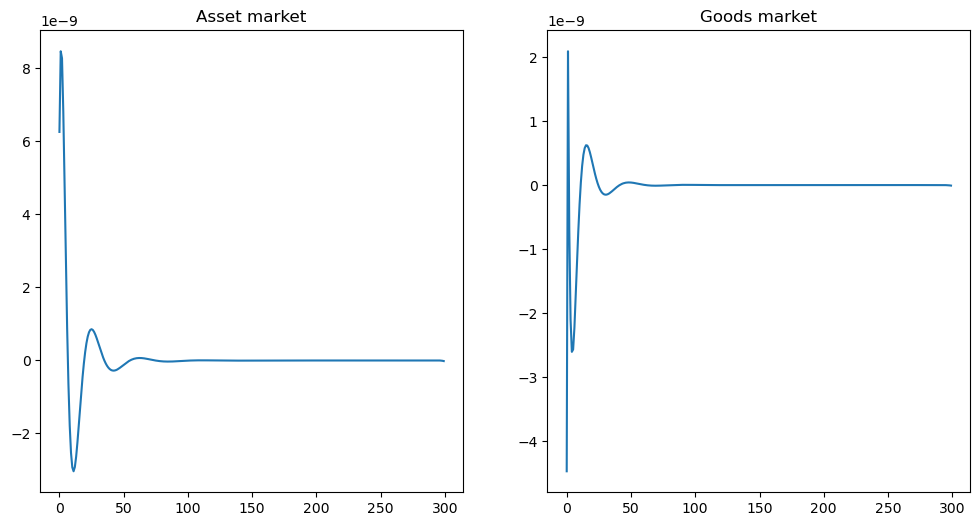

In [24]:
fig, axes = plt.subplots(2, 3, figsize=(12, 6))

axes[0, 0].plot((Gamma_shock-par.Gamma)/par.Gamma * 100)
axes[0, 0].set_title('Gamma')
axes[0, 1].plot((Y_trans-Y_ss)/Y_ss * 100)
axes[0, 1].set_title('Y')
axes[0, 2].plot((K_trans-K_ss)/K_ss * 100)
axes[0, 2].set_title('K')
axes[1, 0].plot((r_trans-r_ss)* 100)
axes[1, 0].set_title('r')
axes[1, 1].plot((r_trans-r_ss)* 100)
axes[1, 1].set_title('rK')
axes[1, 2].plot((w_trans-w_ss) / w_ss* 100)
axes[1, 2].set_title('w')
for ax in axes.flat: 
    ax.set_xlim(-5, 300)
    ax.grid(True, alpha =0.3)
plt.show()


fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].plot(A_trans-K_trans)
axes[0].set_title('Asset market')
axes[1].plot(Y_trans - C_trans - I_trans)
axes[1].set_title('Goods market')
plt.show()

### <a id='toc1_3_2_'></a>[A 'manual Jacobian' approach](#toc0_)

Another approach is to use an quasi-Newton method. Recall that, for a function $H(\mathbf{x})$, Newton's method allow us to find $\mathbf{x}$ such that $H(\mathbf{x})=\mathbf{0}$ (note that $H(.)$ returns a vector here) by iterating over this mapping:
$$
\mathbf{x}^{n+1}=\mathbf{x}^n - J(\mathbf{x^n})^{-1} H(\mathbf{x^n}) 
$$
where $J(\mathbf{x})$ is the Jacobian matrix of $H$. 

In our case, $H(.)$ is the market clearing equation, $\mathbf{x}$ is the vector $\{K_t\}_{t=0}^T$, but what is $J$? 

We call $J$ the **sequence-space Jacobian**!

### Intuitive derivation

First, write the asset market clearing equation as 
$$
\begin{aligned}
H(K_t, \Gamma_t)=A_t^{hh}(\{w_t(K_t,\Gamma_t),r_t(K_t,\Gamma_t)\}_{t=0}^T) - K_t \quad \text{for all }t\in(0,T)
\end{aligned}
$$
which we can write in vector notation as 
$$
H(\mathbf{K},\mathbf{\Gamma}) = \mathbf{A}^{hh}(\mathbf{w}(\mathbf{K},\mathbf{Z}),r(\mathbf{K},\mathbf{Z}))-\mathbf{K}
$$

Now, take the derivative with respect to $\mathbf{K}$. This gives us

$$ 
\frac{dH(\mathbf{K},\mathbf{Z})}{d\mathbf{K}} = \frac{d\mathbf{A}}{d\mathbf{w}}\frac{d\mathbf{w}}{d\mathbf{K}}+ \frac{d\mathbf{A}}{d\mathbf{r}}\frac{d\mathbf{r}}{d\mathbf{K}} - \mathbf{I}
$$


The Jacobian with respect to the firms variables are relatively easy to compute, since they only depend on $K_t$ (or $K_{t-1}$ for $r_t$). 

In [25]:
dw_dK_analytical = (1-par.alpha) * par.alpha * par.Gamma * K_ss**(par.alpha-1)
dr_dK_analytical = par.alpha * par.Gamma * (par.alpha-1) * K_ss**(par.alpha-2)

dw_dK = np.zeros((T, T))
dr_dK = np.zeros((T, T))

dw_dK[1:,:-1] = np.eye(T-1) * dw_dK_analytical
dr_dK[1:,:-1] = np.eye(T-1) * dr_dK_analytical

But we need more work for the household Jacobian. Indeed, for every column $s$ of this Jacobian matrix, we need to compute an impulse response following a shock at $s$. This means we need to do $T$ forward and backward step! Let's try it.

In [26]:
T = 300
r_vec = np.ones((T)) * r_ss
w_vec = np.ones((T)) * w_ss

_, A_no_shock, _, _, a_0 = get_impulse_response(Va_term, D_init, r_vec, w_vec, par)
a_ss = a_0[0] # to avoid numerical errors, run a blank transition and update steady state policy functions. This is for numerical precision only, not necessary per se.

In [27]:
h = 1e-4
J_w = np.zeros((T, T))

for s in range(T):
    r_vec = np.ones((T)) * r_ss
    w_vec = np.ones((T)) * w_ss
    
    w_vec[s] = w_ss + h

    C_trans, A_trans, _, _, _ = get_impulse_response(Va_term, D_init, r_vec, w_vec, par)
    J_w[:,s] = (A_trans - A_no_shock) / h

In [28]:
J_r = np.zeros((T, T))

for s in range(T):
    r_vec = np.ones((T)) * r_ss
    w_vec = np.ones((T)) * w_ss

    r_vec[s] = r_vec[s] + h

    C_trans, A_trans, _, _, _ = get_impulse_response(Va_term, D_init, r_vec, w_vec, par)
    J_r[:,s] = (A_trans - A_no_shock) / h

We can then put things together, using the previously derived formula, to compute the full Jacobian of $H(.)$ with respect to a sequence $\mathbf{K}$.

In [29]:
H_K = J_w @ dw_dK + J_r @ dr_dK - np.eye(T)

Now, let's use this Jacobian and Newton's method to solve for the equilibrium.

In [30]:
K_trans = np.ones((T)) * K_ss
error = 1 
tol = 1e-14

while error > tol:
    r_trans, w_trans, Y_trans, I_trans = firm(K_trans, Gamma_shock, K_ss, par)
    C_trans, A_trans, D_trans, c_trans, a_trans = get_impulse_response(Va_term, D_init, r_trans, w_trans, par)
    asset_market = A_trans - K_trans
    error = np.max(np.abs(asset_market))
    print(error)
    K_trans -= np.linalg.solve(H_K, asset_market)

0.2488828875265936
0.004111755894255609
3.9805062640674294e-05
1.20755095700531e-07
1.0458451882300324e-09
7.896794329553813e-12
2.4868995751603507e-14
1.1546319456101628e-14
7.993605777301127e-15


Done in 5 iterations and half a second!

Here we kept the Jacobian constant, but we can also do Broyden's method to update the Jacobian

In [31]:
import numpy as np

def broyden_jacobian_update(J_prev, x_prev, x_curr, f_prev, f_curr, eps=1e-14):
    """
    Good Broyden update for the Jacobian J.

    J_i = J_{i-1} + ((f_i - f_{i-1}) - J_{i-1}(x_i - x_{i-1}))
                      -----------------------------------------  (x_i - x_{i-1})^T
                           ||x_i - x_{i-1}||_2^2
    """
    s = x_curr - x_prev          # step in x
    y = f_curr - f_prev          # change in residual
    denom = float(s @ s)         # ||s||^2
    if denom <= eps:
        return J_prev            # no update if step is too small
    return J_prev + np.outer((y - J_prev @ s), s) / denom


K = np.ones(T) * K_ss
J = H_K.copy()                   # J_0
tol, max_iter = 1e-14, 200

# initial residual
r,w,Y,I = firm(K, Gamma_shock, K_ss, par)
C,A,D,c,a = get_impulse_response(Va_term, D_init, r, w, par)
F = A - K

for it in range(max_iter):
    err = np.max(np.abs(F))
    print(err)
    if err <= tol:
        break

    # step from current Jacobian
    s = -np.linalg.solve(J, F)
    K_new = K + s

    # new residual
    r,w,Y,I = firm(K_new, Gamma_shock, K_ss, par)
    C,A,D,c,a = get_impulse_response(Va_term, D_init, r, w, par)
    F_new = A - K_new

    # Broyden update (formula above)
    J = broyden_jacobian_update(J, K, K_new, F, F_new)

    K, F = K_new, F_new

0.2488828875265936
0.004111755894255609
8.439205156562934e-05
3.016134151323513e-07
9.883089902018583e-10
5.835332217429823e-13
1.8207657603852567e-14
1.865174681370263e-14
1.7763568394002505e-14
1.509903313490213e-14
1.4210854715202004e-14
8.43769498715119e-15


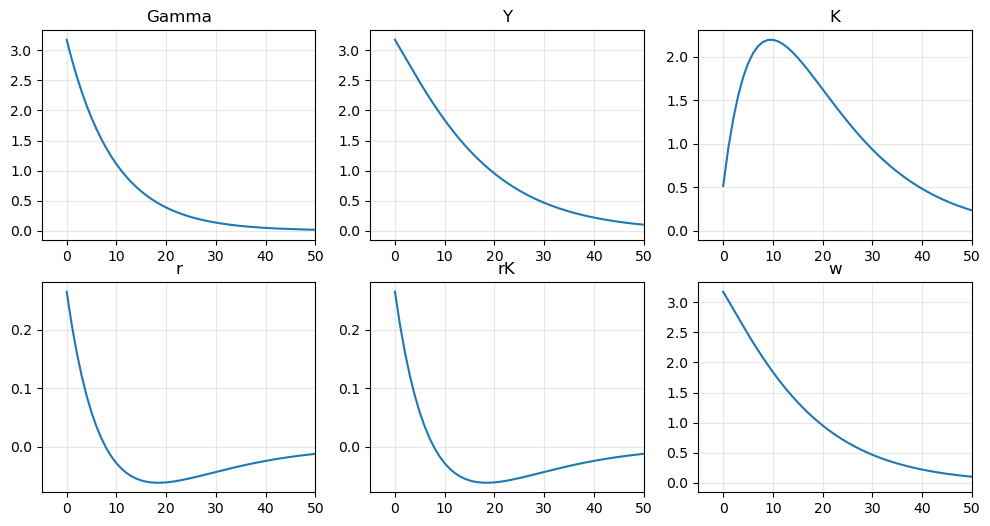

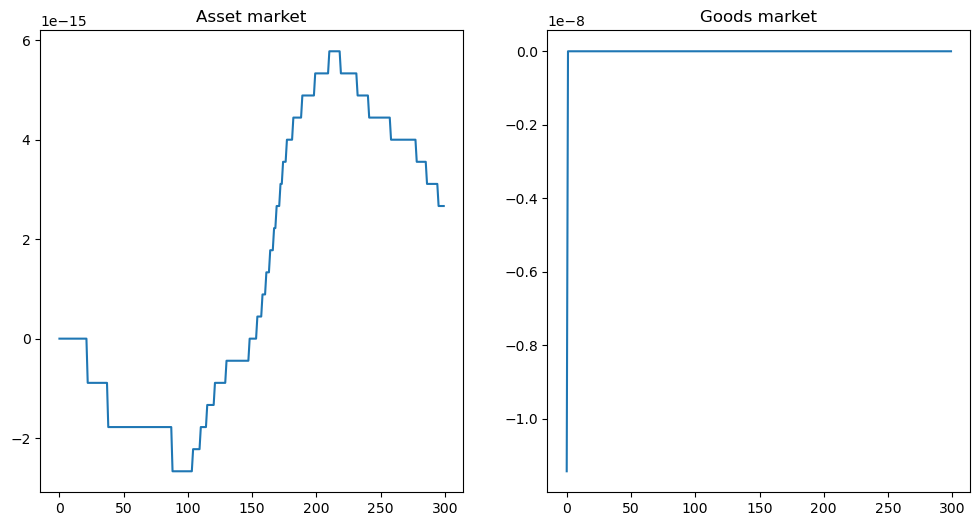

In [32]:
fig, axes = plt.subplots(2, 3, figsize=(12, 6))

axes[0, 0].plot((Gamma_shock-par.Gamma)/par.Gamma * 100)
axes[0, 0].set_title('Gamma')
axes[0, 1].plot((Y_trans-Y_ss)/Y_ss * 100)
axes[0, 1].set_title('Y')
axes[0, 2].plot((K_trans-K_ss)/K_ss * 100)
axes[0, 2].set_title('K')
axes[1, 0].plot((r_trans-r_ss)* 100)
axes[1, 0].set_title('r')
axes[1, 1].plot((r_trans-r_ss)* 100)
axes[1, 1].set_title('rK')
axes[1, 2].plot((w_trans-w_ss) / w_ss* 100)
axes[1, 2].set_title('w')
for ax in axes.flat: 
    ax.set_xlim(-5, 50)
    ax.grid(True, alpha =0.3)
plt.show()


fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].plot(A_trans-K_trans)
axes[0].set_title('Asset market')
axes[1].plot(Y_trans - C_trans - I_trans)
axes[1].set_title('Goods market')
plt.show()

We can reuse the Jocabian to compute the transitions to a new shock if we want! 

Exercise: compute a GE transition following a (huge) TFP shock with $\sigma=0.1$, and plot your results.

In [33]:
T = 300
sigma = 0.1
rho = 0.9
Gamma_shock = par.Gamma + sigma * rho ** np.arange(T)
# Code here

K_trans_new = np.ones((T)) * K_ss
error = 1 
tol = 1e-14

while error > tol:
    r_trans, w_trans, Y_trans, I_trans = firm(K_trans_new, Gamma_shock, K_ss, par)
    C_trans, A_trans, D_trans, c_trans, a_trans = get_impulse_response(Va_term, D_init, r_trans, w_trans, par)
    asset_market = A_trans - K_trans_new
    error = np.max(np.abs(asset_market))
    print(error)
    K_trans_new -= np.linalg.solve(H_K, asset_market)

1.3419288849705708
0.10210792724120799
0.005661540452297054
9.347531911618745e-05
3.1984962980402543e-06
1.2544421590376942e-07
1.6137375880020954e-09
9.102940623506584e-11
2.9549696023423166e-12
5.240252676230739e-14
5.329070518200751e-15


Solved in one second!

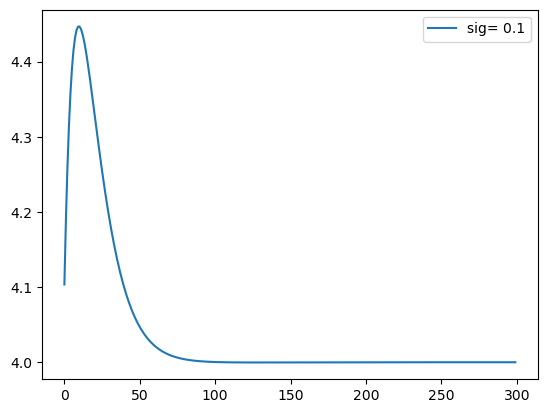

In [34]:
#plt.plot(K_trans, label ='sig= 0.02')
plt.plot(K_trans_new, label ='sig= 0.1')
plt.legend()
plt.show()

### <a id='toc1_3_3_'></a>[The Fake-News algorithm](#toc0_)

We managed to speed up the time to compute a transition significantly, but computing the Jacobian is still costly. Luckily, we can do much faster using the fake-news algorithm of Auclert et al (2021). 

Main insight: for every column $s$ of the Jacobian, all policy functions for $t>s$ are the steady state policy functions. 

Why? What matters is the distance to the shock! This means we can compute one transition for a shock at $s=T$, and back out the policy functions for every column $s$ by reordering them appropriately. 

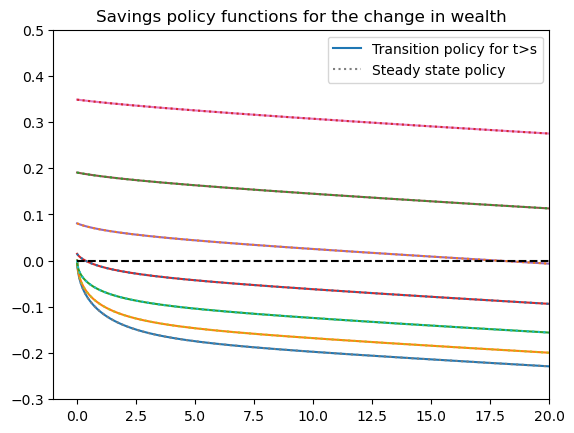

In [49]:
h = 0.01
r_vec = np.ones((T)) * r_ss
w_vec = np.ones((T)) * w_ss

s = 5
w_vec[s] = w_vec[s] + h

_, _, _, c_trans, a_trans = get_impulse_response(Va_term, D_init, r_vec, w_vec, par)

lines1 = plt.plot(par.a_grid, (a_trans[s+1]-par.a_grid[np.newaxis,:]).T)
lines2 = plt.plot(par.a_grid, (a_ss-par.a_grid[np.newaxis,:]).T, linestyle = ':')
plt.plot(np.zeros_like(par.a_grid), linestyle = '--', color = 'black')
lines1[0].set_label('Transition policy for t>s')
lines2[0].set_label('Steady state policy')
plt.xlim(-1, 20)
plt.ylim(-0.3, 0.5)
plt.legend()
plt.title("Savings policy functions for the change in wealth")
plt.show()

Another way to look at it is to see how policy function at a given point change during the transition (in % deviation from steady state policy).

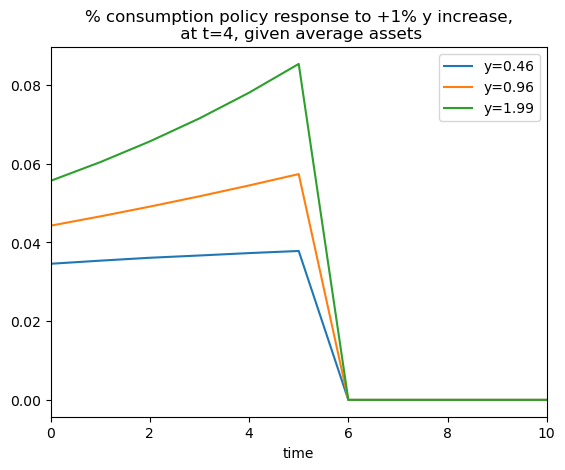

In [36]:
c_impulse = 100*(c_trans - c_ss) / c_ss # percent change in consumption policy function
i_ave = np.argmax(par.a_grid > K_ss) # first index of assets above average
for e in (0, 3, 6):
    plt.plot(c_impulse[:, e, i_ave], label=f"y={par.z_grid[e]:.2f}")
plt.xlim(0,10)
plt.xlabel('time')
plt.legend()
plt.title(f"% consumption policy response to +1% y increase,\n at t=4, given average assets");

Using this intuition, we can do only one backward step, computing the impulse response to a shock at $s=T$, and then rearrange the policy functions in order to compute the Jacobian matrix. 

In practice, this means we only need one backward step, but still $T$ forward steps (the full Fake-News algorithm also has a way to avoid this, but we won't cover it today).

In [50]:
J_w_fake_news = np.zeros((T, T))

# First, compute the impulse response for a shock on w at the last period
r_vec = np.ones((T)) * r_ss
w_vec = np.ones((T)) * w_ss
w_vec[-1] = w_ss + h

_, _, _, _, a_trans_last = get_impulse_response(Va_term, D_init, r_vec, w_vec, par)

# Discretize the policies
a_i_last, a_pi_last = get_lottery(a_trans_last, par.a_grid)
a_i_ss,   a_pi_ss   = get_lottery(np.broadcast_to(a_ss,(T,)+a_ss.shape), par.a_grid)

# Rearange them and do a forward path for each s 
for s in range(T):
    a_path = np.broadcast_to(a_ss,(T,)+a_ss.shape).copy()
    a_path[:s+1] = a_trans_last[T-1-s:]  # distance invariance

    ai = a_i_ss.copy()
    ap = a_pi_ss.copy()
    ai[:s+1] = a_i_last[T-1-s:]
    ap[:s+1] = a_pi_last[T-1-s:]

    D_trans = forward_iteration_trans(D_init, par.z_trans, ai, ap, T)
    A_trans = np.sum(D_trans * a_path, axis=(1,2))
    J_w_fake_news[:, s] = (A_trans - A_no_shock) / h

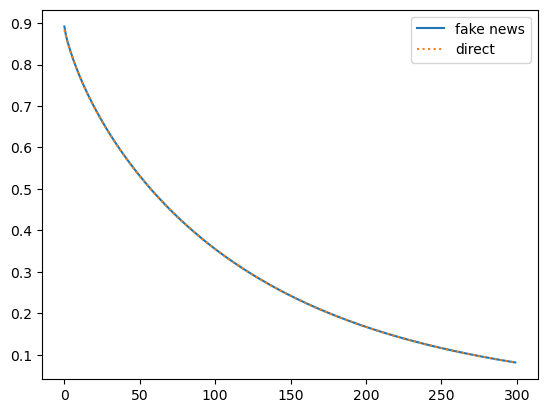

In [51]:
s = 0
plt.plot(J_w_fake_news[:,s], label = 'fake news')
plt.plot(J_w[:,s], linestyle = ':', label = 'direct')
plt.legend()
plt.show()

We can use the same code to compute the Jacobian with respect to $r$ using the fake-news algorithm again.

In [52]:
J_r_fake_news = np.zeros((T, T))

# First, compute the impulse response for a shock on w at the last period
r_vec = np.ones((T)) * r_ss
w_vec = np.ones((T)) * w_ss
r_vec[-1] = r_ss + h

_, _, _, _, a_trans_last = get_impulse_response(Va_term, D_init, r_vec, w_vec, par)

# Discretize the policies
a_i_last, a_pi_last = get_lottery(a_trans_last, par.a_grid)
a_i_ss,   a_pi_ss   = get_lottery(np.broadcast_to(a_ss,(T,)+a_ss.shape), par.a_grid)

# Rearange them and do a forward path for each s 
for s in range(T):
    a_path = np.broadcast_to(a_ss,(T,)+a_ss.shape).copy()
    a_path[:s+1] = a_trans_last[T-1-s:]  # distance invariance

    ai = a_i_ss.copy()
    ap = a_pi_ss.copy()
    ai[:s+1] = a_i_last[T-1-s:]
    ap[:s+1] = a_pi_last[T-1-s:]

    D_trans = forward_iteration_trans(D_init, par.z_trans, ai, ap, T)
    A_trans = np.sum(D_trans * a_path, axis=(1,2))
    J_r_fake_news[:, s] = (A_trans - A_no_shock) / h

## Linear transitions

So far, we have computed MIT (perfect-foresight) shocks. At the steady-state, households believe there is no chance such a shock happens. Once the shock happens at $t=0$, they have perfect foresight over the path of $r$ and $w$, and believe no shock will happen again (strong assumption).

Another way it to take a linear 

In [53]:
dr_dZ_analytical = par.alpha * K_ss**(par.alpha-1)
dw_dZ_analytical = (1-par.alpha) * K_ss**par.alpha

dr_dZ = np.eye(T) * dr_dZ_analytical
dw_dZ = np.eye(T) * dw_dZ_analytical

In [54]:
T = 300
sigma = 0.02
rho = 0.9
dGamma = sigma * rho ** np.arange(T) 

H_K = J_w_fake_news @ dw_dK + J_r_fake_news @ dr_dK - np.eye(T)
H_Z = J_w_fake_news @ dw_dZ + J_r_fake_news @ dr_dZ  
G = -np.linalg.solve(H_K, H_Z) 
dK = G @ dGamma

In [55]:
K_trans = np.ones((T)) * K_ss
error = 1 
tol = 1e-8
adj = 0.1
while error > tol:
    r_trans, w_trans, Y_trans, I_trans = firm(K_trans, (par.Gamma +dGamma), K_ss, par)
    C_trans, A_trans, D_trans, c_trans, a_trans = get_impulse_response(Va_term, D_init, r_trans, w_trans, par)
    asset_market = A_trans - K_trans
    error = np.max(np.abs(asset_market))
    print(error)
    K_trans -= np.linalg.solve(H_K, asset_market)


0.2488828875265936
0.003718450346442026
5.221311910386106e-05
3.415740357226582e-07
3.3848799319002865e-09


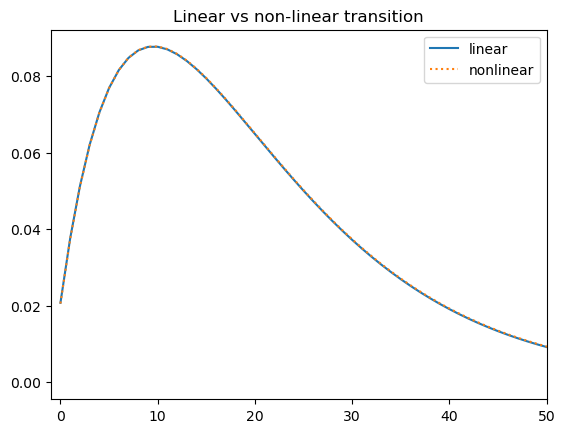

In [56]:
plt.plot(dK, label = 'linear')
plt.plot(K_trans - K_ss, label = 'nonlinear', linestyle = ':')
plt.xlim(-1, 50)
plt.legend()
plt.title('Linear vs non-linear transition')
plt.show()

It works! But what happens if we take a big shock?

2.9336070063048716
0.38881533085186515
0.05117529535019383
0.0020898327771590175
0.00011449139582708767
9.219921765613037e-06
2.464848956051924e-07
2.6942698738707804e-08
1.773938329563407e-09


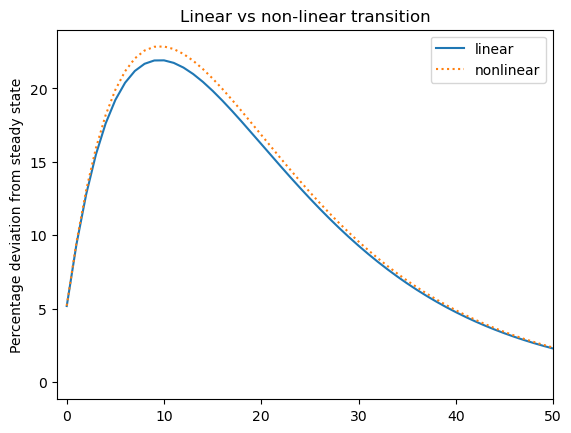

In [57]:
T = 300
sigma = 0.2
rho = 0.9
dGamma = sigma * rho ** np.arange(T) 

H_K = J_w_fake_news @ dw_dK + J_r_fake_news @ dr_dK - np.eye(T)
H_Z = J_w_fake_news @ dw_dZ + J_r_fake_news @ dr_dZ  
G = -np.linalg.solve(H_K, H_Z) 
dK = G @ dGamma

K_trans = np.ones((T)) * K_ss
error = 1 
tol = 1e-8
adj = 0.1
while error > tol:
    r_trans, w_trans, Y_trans, I_trans = firm(K_trans, (par.Gamma +dGamma), K_ss, par)
    C_trans, A_trans, D_trans, c_trans, a_trans = get_impulse_response(Va_term, D_init, r_trans, w_trans, par)
    asset_market = A_trans - K_trans
    error = np.max(np.abs(asset_market))
    print(error)
    K_trans -= np.linalg.solve(H_K, asset_market)

plt.plot(dK/K_ss * 100, label = 'linear')
plt.plot((K_trans - K_ss)/K_ss * 100, label = 'nonlinear', linestyle = ':')
plt.xlim(-1, 50)
plt.legend()
plt.ylabel('Percentage deviation from steady state')
plt.title('Linear vs non-linear transition')
plt.show()

We find some differences between the linear and non-linear show up because of non-linearities.

## Simulating the model 

We have seen that once we have obtained the Jacobian, we can compute IRFs really fast. How could we simulate the economy facing a sequence of shocks? 

First, assume that TFP innovations follow an AR-1 process:
$$
d\Gamma_t = \rho d\Gamma_{t-1} +\sigma \varepsilon_t
$$

In [59]:
rho = 0.9 
sigma = 0.01 
T = 300

dGamma = sigma * rho ** np.arange(T)
IRF_K = G @ dGamma  

simT = 2000
epsilon = np.random.normal(0.0, 1.0, simT)

simT = epsilon.shape[0]
K_sim = np.zeros(simT)
for t in range(simT):
    K_sim[t] = 0.0
    for s in range(T):
        if t-s >= 0:
            K_sim[t] += IRF_K[s]*(epsilon[t-s])

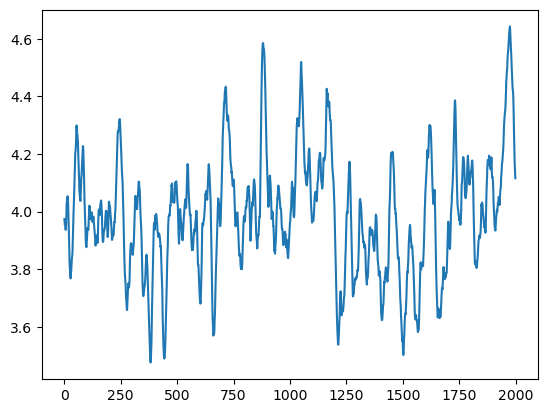

In [60]:
plt.plot(K_ss+K_sim)

In [61]:
Gamma_sim = np.zeros(simT) 

for t in range(simT):
    if t == 0:
        Gamma_sim[t] = sigma * epsilon[t]
    else:
        Gamma_sim[t] = rho * Gamma_sim[t-1] + sigma * epsilon[t]

Text(0, 0.5, 'dGamma')

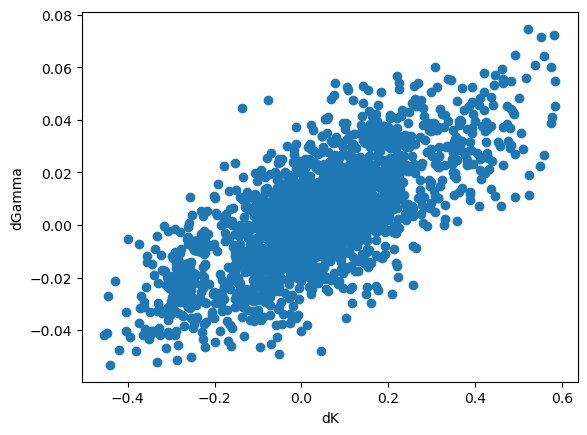

In [48]:
plt.scatter(K_sim, Gamma_sim)
plt.xlabel('dK')
plt.ylabel('dGamma')